<a href="https://colab.research.google.com/github/AndreTeixeir/hackathon-one-sentiment-api/blob/main/datascience/Hackathon_One_Nb3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='orange'> **SentimentAPI — Análise de Sentimentos de Avaliações**

- <font color='red'> **Notebook 3 – Avaliando Desempenho do Modelo Ternário**

## Projeto desenvolvido no Hackathon ONE

**Objetivo:**  
Construir um modelo de Machine Learning capaz de classificar o sentimento
(positivo / negativo / neutro) de avaliações textuais, integrável a uma API.

**Equipe de Data Science:**  
- Brena Stephany  
- Eyka Albuquerque
- Leticia

**Modelo:** TF-IDF + Logistic Regression  

# <font color='blue'>**Importação de Bibliotecas**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

!pip install nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report)

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
import joblib

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# <font color='blue'>**Extração dos Dados**

Extração dos dados já tratados no Notebook 1

In [ ]:
url = "https://raw.githubusercontent.com/AndreTeixeir/hackathon-one-sentiment-api/refs/heads/main/datascience/dataset_sentimento_limpo.csv"
df = pd.read_csv(url, sep=',')
df.head()


,comentario,nota,data,tamanho_texto,sentimento
0,filas de mais de horas nos brinquedosfilas de ...,1.0,mar de 2023,242,0
1,parque lotado fila da montezum demorou mais de...,3.0,mar de 2023,400,0
2,muito ruim caiu na qualidade muito demorado um...,1.0,mar de 2023,121,0
3,o parque atende a diversas faixa etária fomos ...,4.0,fev de 2023,1145,1
4,decadentesó vá ao parque sea você poder perder...,2.0,fev de 2023,447,0


# <font color='blue'>**Criando a variável alvo ternária**

In [ ]:
def map_sentiment_ternario(nota):
    if nota >= 4:
        return 2  # Positivo
    elif nota == 3:
        return 1  # Neutro
    else:
        return 0  # Negativo

df['sentimento'] = df['nota'].apply(map_sentiment_ternario)

In [ ]:
df['sentimento'].value_counts()

,count
sentimento,
2,1887
0,1230
1,927


## **Balanceamento (Undersampling)**

**Objetivo do Undersampling**

Reduzir o número de exemplos Positivos para:

* Diminuir viés do modelo

* Melhorar desempenho do Neutro

* Manter informação suficiente para aprendizado

In [ ]:
df_neg = df[df['sentimento'] == 0]
df_neu = df[df['sentimento'] == 1]
df_pos = df[df['sentimento'] == 2]

In [ ]:
df_pos_under = resample(
    df_pos,
    replace=False,              # undersampling → sem reposição
    n_samples=len(df_neg),      # mesmo tamanho da classe Negativa
    random_state=42 )

In [ ]:
df_bal = pd.concat([df_neg, df_neu, df_pos_under])

In [ ]:
df_bal = df_bal.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
df_bal['sentimento'].value_counts()

,count
sentimento,
0,1230
2,1230
1,927


Para reduzir o viés do modelo em relação à classe positiva, foi aplicada uma estratégia de undersampling controlado, reduzindo a quantidade de exemplos positivos para um valor próximo ao da classe negativa. Essa abordagem, combinada ao uso de class_weight='balanced', permitiu um treinamento mais equilibrado, preservando a diversidade textual e melhorando a capacidade de generalização do modelo.

# <font color='blue'>**Separação das variáveis**

In [ ]:
X = df_bal['comentario']
y = df_bal['sentimento']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y )

# <font color='blue'>**Vetorização de Texto (TF-IDF)**

Transformação dos Textos com TF-IDF

In [ ]:
stopwords_pt = stopwords.words('portuguese')

In [ ]:
tfidf = TfidfVectorizer(
    max_features=1000,
    min_df=2,
    max_df=0.95,
    ngram_range=(1, 3),
    stop_words=stopwords_pt
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
X_train_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 78439 stored elements and shape (2709, 1000)>

In [ ]:
tfidf.get_feature_names_out()[:20]

array(['abandonado', 'abandono', 'abertas', 'aberto', 'abertos',
       'abertura', 'abre', 'abrem', 'abrir', 'abriu', 'absurdamente',
       'absurdo', 'absurdos', 'abusivo', 'abusivos', 'acaba', 'acabou',
       'acesso', 'achei', 'acho'], dtype=object)

# <font color='blue'>**Treinando a Regressão Logística Ternária**

In [ ]:
model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    multi_class='auto' )

model.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=1000, multi_class='auto')

O parâmetro multi_class='auto' foi utilizado para permitir que o modelo selecionasse automaticamente a melhor estratégia de classificação conforme o número de classes e o solver adotado.

In [ ]:
#Previsões no conjunto de teste
y_pred = model.predict(X_test_tfidf)
y_proba = model.predict_proba(X_test_tfidf)

# <font color='blue'>**Avaliação do Modelo Ternário**

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1-score (macro): {f1:.4f}")

Acurácia: 0.7035
Precisão (macro): 0.6937
Recall (macro): 0.6927
F1-score (macro): 0.6927


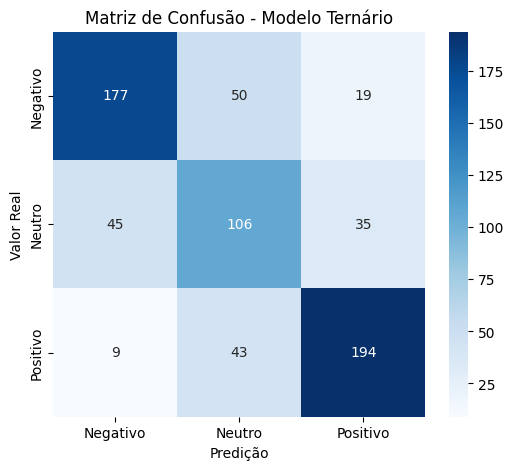

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Negativo', 'Neutro', 'Positivo'],
    yticklabels=['Negativo', 'Neutro', 'Positivo']
)

plt.xlabel('Predição')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusão - Modelo Ternário')
plt.show()

In [ ]:
print(classification_report(
    y_test,
    y_pred,
    target_names=['Negativo', 'Neutro', 'Positivo'] ))

              precision    recall  f1-score   support

    Negativo       0.77      0.72      0.74       246
      Neutro       0.53      0.57      0.55       186
    Positivo       0.78      0.79      0.79       246

    accuracy                           0.70       678
   macro avg       0.69      0.69      0.69       678
weighted avg       0.71      0.70      0.71       678



# <font color='blue'>**Teste manual (comparável ao binário)**

In [ ]:
textos_teste = [
    "O atendimento foi excelente, muito rápido e eficiente",
    "Produto péssimo, chegou quebrado e não recomendo",
    "Demorou bastante para chegar, mas o produto é bom",
    "O produto quebrou logo, odiei",
    "Entrega dentro do prazo, nada demais",
    "Funciona como esperado, nada além do básico.",
    "Atende ao que foi proposto, sem grandes destaques.",
    "Entrega normal e produto padrão.",
    "Demora absurda na entrega e atendimento ruim.",
    "O produto parou de funcionar em poucos dias.",
    "Dinheiro jogado fora, muito decepcionante."]

X = tfidf.transform(textos_teste)
preds = model.predict(X)
probs = model.predict_proba(X)

labels = ['Negativo', 'Neutro', 'Positivo']

for texto, pred, prob in zip(textos_teste, preds, probs):
    print("Texto:", texto)
    print("Previsão:", labels[pred])
    print("Probabilidade:", round(max(prob), 2))
    print("-" * 50)

Texto: O atendimento foi excelente, muito rápido e eficiente
Previsão: Positivo
Probabilidade: 0.72
--------------------------------------------------
Texto: Produto péssimo, chegou quebrado e não recomendo
Previsão: Negativo
Probabilidade: 0.72
--------------------------------------------------
Texto: Demorou bastante para chegar, mas o produto é bom
Previsão: Positivo
Probabilidade: 0.62
--------------------------------------------------
Texto: O produto quebrou logo, odiei
Previsão: Positivo
Probabilidade: 0.46
--------------------------------------------------
Texto: Entrega dentro do prazo, nada demais
Previsão: Positivo
Probabilidade: 0.5
--------------------------------------------------
Texto: Funciona como esperado, nada além do básico.
Previsão: Negativo
Probabilidade: 0.47
--------------------------------------------------
Texto: Atende ao que foi proposto, sem grandes destaques.
Previsão: Positivo
Probabilidade: 0.48
--------------------------------------------------
Texto:

## <font color='red'>**Relatório de Avaliação: Comparação entre Modelos Binário e Ternário**

Durante o desenvolvimento do projeto, foram testadas diferentes abordagens para classificação de sentimentos, incluindo modelos binários (Positivo / Negativo) e ternários (Positivo / Neutro / Negativo), utilizando Regressão Logística com vetorização TF-IDF. Para o modelo ternário, foram aplicadas técnicas de balanceamento de classes e ajuste de pesos, visando melhorar seu desempenho.

Apesar desses esforços, o modelo ternário apresentou desempenho inferior ao binário, especialmente em relação a **Acurácia** de **0,70** contra os **0,85** do modelo binário, também na classe Neutra, que obteve métricas significativamente mais baixas de precisão e recall. Esse resultado é esperado, pois a classe neutra representa um conceito semanticamente mais ambíguo, com fronteiras menos bem definidas no espaço vetorial gerado pelo TF-IDF. Diferentemente das classes positiva e negativa, que possuem vocabulário mais característico, textos neutros tendem a compartilhar termos com ambas, dificultando a separação pelo modelo linear.

Além disso, o aumento da complexidade do problema, ao passar de duas para três classes, exige maior volume e diversidade de dados para que o modelo consiga generalizar adequadamente. Mesmo com balanceamento, a quantidade e a qualidade dos exemplos neutros não foram suficientes para superar essa limitação estrutural.

Dessa forma, o modelo binário demonstrou maior estabilidade, melhor desempenho global e maior confiabilidade para uso em um MVP, sendo considerado mais adequado para os objetivos do projeto. O modelo ternário permanece como uma possibilidade de evolução futura, especialmente com a ampliação do dataset ou a adoção de modelos mais avançados de linguagem.